In [1]:

# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from feature_extraction import texture_statistics_gabor, sketch_token_features, \
                texture_statistics_pyramid, alexnet_features
from utils import nsd_utils, roi_utils, default_paths, coco_utils

from model_fitting import initialize_fitting, arg_parser, merge_features
from model_fitting import fwrf_fit, fwrf_predict, reconstruct

fpX = np.float32
# device = initialize_fitting.init_cuda()
device = 'cpu:0'

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"


Initializing coco api...
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
loading annotations into memory...
Done (t=15.86s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
loading annotations into memory...
Done (t=12.41s)
creating index...
index created!


In [2]:
subject = 1
volume_space=True
up_to_sess = 1
single_sess = None
ridge = 1
gabor_nonlin_fn=False
which_prf_grid=5


In [4]:
# decide what voxels to use  
voxel_mask, voxel_index, voxel_roi, voxel_ncsnr, brain_nii_shape = roi_utils.get_voxel_roi_info(subject, \
                                                        volume_space, include_all=True, include_body=True)

if single_sess is not None:
    sessions = np.array([single_sess])
else:
    sessions = np.arange(0,up_to_sess)
zscore_betas_within_sess = True
image_inds_only = True
# get all data and corresponding images, in two splits. always fixed set that gets left out
trn_stim_data, trn_voxel_data, val_stim_data, val_voxel_data, \
        image_order, image_order_trn, image_order_val = nsd_utils.get_data_splits(subject, \
                                  sessions=sessions, image_inds_only = image_inds_only, \
                                  voxel_mask=voxel_mask, volume_space=volume_space, \
                                  zscore_betas_within_sess=zscore_betas_within_sess)

if image_inds_only==True:
    # For this model, the features are pre-computed, so we will just load them rather than passing in images.
    # Going to pass the image indices (into 10,000 dim array) instead of images to fitting and val functions, 
    # which will tell which features to load.
    trn_stim_data = image_order_trn
    val_stim_data = image_order_val

In [4]:
# zscore_features=True
# # More params for fitting
# holdout_size, lambdas = initialize_fitting.get_fitting_pars(trn_voxel_data, zscore_features, ridge=ridge, gabor_nonlin_fn=gabor_nonlin_fn)
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range, which_grid=which_prf_grid) 

number of pRFs: 1456
most extreme RF positions:
[2.7755576e-17 0.0000000e+00 2.0000000e-02]
[ 0.7698996  -0.31890285  1.        ]


In [ ]:
use_pca_st_feats=0
min_pct_var=None
max_pc_to_retain=None
use_lda_st_feats=0
lda_discrim_type=None
zscore_in_groups=0
_feature_extractor = sketch_token_features.sketch_token_feature_extractor(subject=subject, device=device,\
             which_prf_grid=which_prf_grid, \
             use_pca_feats = use_pca_st_feats, min_pct_var = min_pct_var, max_pc_to_retain = max_pc_to_retain, \
             use_lda_feats = use_lda_st_feats, lda_discrim_type = lda_discrim_type, zscore_in_groups = zscore_in_groups)

In [5]:
fn2save = '/user_data/mmhender/imStat/model_fits/S01/sketch_tokens/Nov-11-2021_1659_27/all_fit_params'

out = torch.load(fn2save)
best_losses = out['best_losses']
best_lambdas = out['best_lambdas']
best_params = out['best_params']
val_cc = out['val_cc']
val_r2 = out['val_r2']
val_voxel_data_pred = out['val_voxel_data_pred']
val_voxel_data = out['val_voxel_data']
val_stim_data = out['val_stim_data']

In [ ]:
sample_batch_size=100
voxel_batch_size=100
debug=False
image_size = None
_feature_extractor.init_for_fitting(image_size=image_size, models=models, dtype=fpX)
val_cc, val_r2, val_voxel_data_pred, features_each_prf = \
            fwrf_predict.validate_fwrf_model(best_params, models, val_voxel_data, val_stim_data, \
                     _feature_extractor, zscore=zscore_features, sample_batch_size=sample_batch_size, \
                                         voxel_batch_size=voxel_batch_size, debug=debug, dtype=fpX)
                  

Initializing for fitting
Clearing features from memory
will z-score each column
Clearing features from memory
Getting features for prf 0: [x,y,sigma] is [0.00 0.00 0.0200]
Loading pre-computed features from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf_grid5.h5py


In [6]:
labels_all = coco_utils.load_labels_each_prf(subject, which_prf_grid, \
                                                 image_inds=val_stim_data, models=models,verbose=False)
# discrim_each_axis = fwrf_predict.get_semantic_discrim(best_params, labels_all, \
#                                           val_voxel_data_pred, debug=debug)


loading labels from folders at /user_data/mmhender/nsd_stimuli/labels/ and /user_data/mmhender/nsd_stimuli/labels/S1_within_prf_grid5 (will be slow...)


In [8]:
best_models, weights, bias, features_mt, features_st, best_model_inds = best_params
n_voxels = val_voxel_data_pred.shape[1]

n_sem_axes = labels_all.shape[1]
discrim_each_axis = np.zeros((n_voxels, n_sem_axes))

In [104]:
# vv = np.argmax(val_cc)
discrim_type_list = ['indoor_outdoor','animacy','person','food','vehicle','animal']
aa = 5
vv = np.argmax(out['discrim_each_axis'][:,aa])
# vv = np.argmax(out['discrim_each_axis'][:,aa])
resp_pred = val_voxel_data_pred[:,vv,0]
resp_raw = val_voxel_data[:,vv]

In [105]:
np.corrcoef(val_voxel_data[:,vv], val_voxel_data_pred[:,vv,0])

array([[1.        , 0.04475119],
       [0.04475119, 1.        ]])

In [106]:
out['val_cc'][vv,0]

0.04475119

In [107]:
# aa=0
labels = labels_all[:,aa,best_model_inds[vv,0]]
inds2use = ~np.isnan(labels)
inds1 = (labels==0) & inds2use
inds2 = (labels==1) & inds2use

print([np.sum(inds1), np.sum(inds2)])

[1481, 10]


In [108]:
(np.mean(resp_pred[inds1]) - np.mean(resp_pred[inds2]))/ \
                                                    np.std(resp_pred[inds2use]) 

1.8989944

In [109]:
sd1 = np.std(resp_pred[inds1])
sd2 = np.std(resp_pred[inds2])
n1 = np.sum(inds1)
n2 = np.sum(inds2)
pooled_sd = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2)/(n1+n2-2))

In [110]:
(np.mean(resp_pred[inds1]) - np.mean(resp_pred[inds2]))/pooled_sd

1.9229551177996542

In [111]:
sd1 = np.std(resp_raw[inds1])
sd2 = np.std(resp_raw[inds2])
n1 = np.sum(inds1)
n2 = np.sum(inds2)
pooled_sd = np.sqrt(((n1-1)*sd1**2 + (n2-1)*sd2**2)/(n1+n2-2))

In [112]:
pooled_sd

1.0038143109352924

In [113]:
np.std(resp_raw[inds2use])

1.0040582631256023

In [114]:
(np.mean(resp_raw[inds1]) - np.mean(resp_raw[inds2]))/pooled_sd

0.3427737163195587

In [70]:
print([np.std(resp_pred[inds1]), np.std(resp_pred[inds2])])

[0.07810927, 0.09639264]


In [117]:
print([np.mean(resp_pred[inds1]), np.mean(resp_pred[inds2]), np.std(resp_pred[inds2use])])

[-4.619557e-05, -0.087824784, 0.046223722]


In [116]:
print([np.mean(resp_raw[inds1]), np.mean(resp_raw[inds2]), np.std(resp_raw[inds2use])])

[0.010675885466117334, -0.33340527638792994, 1.0040582631256023]


In [115]:
(np.mean(resp_raw[inds1]) - np.mean(resp_raw[inds2]))/ \
                                                    np.std(resp_raw[inds2use]) 

0.3426904339026435

Text(0, 0.5, 'prediction of sketch tokens fit')

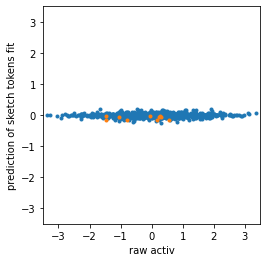

In [118]:
import matplotlib.pyplot as plt
plt.figure();
plt.plot(resp_raw[inds1], resp_pred[inds1],'.')
plt.plot(resp_raw[inds2], resp_pred[inds2],'.')
plt.axis('square')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.xlabel('raw activ')
plt.ylabel('prediction of sketch tokens fit')

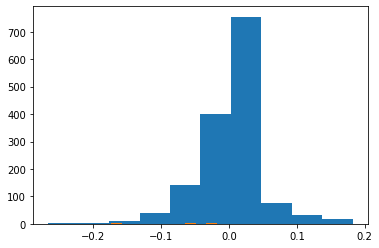

In [120]:
plt.figure();
plt.hist(resp_pred[inds1]);
plt.hist(resp_pred[inds2]);

In [102]:
out['discrim_each_axis'][vv,aa]

-0.2348313182592392

In [123]:
import pandas as pd
labels = pd.read_csv(os.path.join(default_paths.stim_labels_root,'shared_1000_all_labels_matrix.csv'))
labels

,nsdId,cvatId,cocoId,cocoSplit,food_object_card_ratio,food_space_ratio_cmp_objects,food_space_ratio_cmp_image,food_centrality,food_relevance_caption,indoor,...,animal-face,animal-body,food,drink,food-related,faux-food,zoom,reach,large-scale-scene,object
0,23993,300,65400,train2017,0.870968,0.413685,0.031989,1,0,0,...,0,1,1,0,1,0,0,0,0,0
1,23883,299,327191,train2017,0.000000,0.000000,0.000000,0,0,1,...,0,0,0,0,0,0,0,0,1,1
2,23876,298,65029,train2017,0.090909,0.043605,0.004750,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,23871,297,65012,train2017,0.000000,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,23729,296,64534,train2017,0.000000,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,44412,605,406595,train2017,0.000000,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,1
996,44369,604,406445,train2017,0.000000,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
997,44339,603,144193,train2017,0.000000,0.000000,0.000000,0,0,0,...,1,1,0,0,0,0,0,0,1,0
998,44324,602,406292,train2017,0.000000,0.000000,0.000000,0,0,0,...,0,1,0,0,0,0,0,0,1,0
